# Unsupervised Learning

### After trying out supervised learning methods, it's now time to try unsupervised learning. Here we use clustering by k-means with BOW and Tf-Idf. We also explore LDA or Latent Dirichlet Allocation to see if we can capture topics from our tweets. Though the tweet keywords I've used are words like "flu", "sick", "fever", "cold", twitter still returned tweets that are unrelated or words that are meant to explain another meaning that unrelated to health. For example, many tweets would say, "It's cold outside" vs. "I'm sick with cold and flu". We will see if the clustering or the LDA can get us a better understanding of the context of words. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
#import string
import operator
import itertools
import spacy
spacy.load('en')
from spacy.lang.en import English
from spacy.pipeline import SentenceSegmenter
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en')

import nltk
from nltk.corpus import stopwords
from nltk.util import everygrams
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
nltk.download('wordnet')
#import matplotlib.font_manager as fm
#for trying LDA later on
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis.gensim
import gensim
from gensim import corpora

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score


[nltk_data] Downloading package wordnet to /Users/Fcue/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# LOADING DATA from the supervised learning part. I've cleaned this data already :) 
df=pd.read_csv('data/cleaned_tweets.csv')
#some nans were created during cleaning
df.dropna(inplace=True)

In [3]:
#shuffling data
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
#some rows needed to be reindexed 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4164 entries, 0 to 4163
Data columns (total 15 columns):
Unnamed: 0                4164 non-null int64
text                      4164 non-null object
label                     4164 non-null int64
text_noURLs               4164 non-null object
text_punct                4164 non-null object
text_removeRT             4164 non-null object
tokenized                 4164 non-null object
nonstop                   4164 non-null object
Tweet_lemmatized          4164 non-null object
stemmed                   4164 non-null object
remove_less_freq          4164 non-null object
remove_less_freq_lemma    4164 non-null object
document                  4164 non-null object
document_lemma            4164 non-null object
document_stemmed          4164 non-null object
dtypes: int64(2), object(13)
memory usage: 488.1+ KB


## Let's try to use a simple Bag of Words with K-means and try to gain some insight into the cluster of words 

In [5]:
#extended punctuation list
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

#create a bag of words using CountVectorizer.
cv = CountVectorizer(max_features=1000,
                     binary= True,
                     analyzer='word',
                     max_df=0.80,
                     min_df=10, 
                     stop_words=stop_words,
                     strip_accents='ascii',
                     ngram_range=(1, 1),
                     )

count_vector = cv.fit_transform(df['document_lemma'])
#extracting features 
columns = list(cv.get_feature_names())
print('There are {} features'.format(len(columns)))
print(columns[0:20])

# Convert bag of words to a dataframe
count_vectordf = pd.DataFrame(count_vector.toarray(), columns=columns)
count_vectordf.head()

There are 499 features
['able', 'absolutely', 'according', 'ache', 'actually', 'administration', 'adult', 'age', 'ago', 'air', 'allergy', 'american', 'amp', 'antibiotic', 'aom', 'aore', 'aos', 'aot', 'aove', 'apparently']


,able,absolutely,according,ache,actually,administration,adult,age,ago,air,...,worst,wrong,wtf,yall,yeah,year,yes,yesterday,young,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#splitting our bag of words and comparing against label
X_train, X_test, y_train, y_test = train_test_split(count_vectordf, 
                                                    df['label'], 
                                                    test_size=0.25, 
                                                    random_state=0)

In [7]:
from sklearn.cluster import KMeans
 
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0, n_init=20)

# Fit and predict the model. 
y_pred = kmeans.fit_predict(X_train)

pd.crosstab(y_train, y_pred)

col_0,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,0,30,167,74,468,778,115,722,122,15
1,1,2,88,67,5,422,19,27,1,0


In [8]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
# Evaluate the performance of the clusters

print('Adjusted Rand Score: {:.2f}'.format(adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:.2f}'.format(silhouette_score(X_train, y_pred, metric='euclidean')))

Adjusted Rand Score: 0.00
Silhouette Score: 0.07


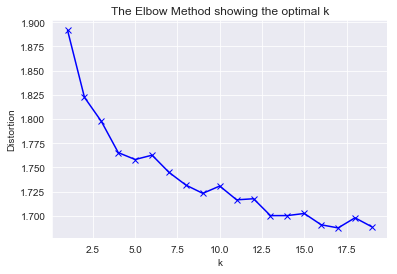

In [9]:
from scipy.spatial.distance import cdist
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    kmeanModel.fit(X_train)
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_train.shape[0])

# Plot the elbow f
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [10]:
from sklearn.cluster import KMeans
 
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, max_iter=1000)

# Fit and predict the model. 
y_pred = kmeans.fit_predict(X_train)

print('Adjusted Rand Score: {:.2f}'.format(adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:.2f}'.format(silhouette_score(X_train, y_pred, metric='euclidean')))

pd.crosstab(y_train, y_pred)

Adjusted Rand Score: -0.04
Silhouette Score: 0.07


col_0,0,1,2,3,4
label,,,,,
0,1,800,583,27,1080
1,0,32,11,6,583


# Using Tf-IDF with K means clusters

In [11]:
# Split original into train and test, used to look at text later
from sklearn.feature_extraction import text
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%", 'pron']
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

X_train, X_test, y_train, y_test = train_test_split(df['document'], 
                                                    df['label'], test_size=0.25, random_state=0)
                                            

#tuning our tfidf, trying to see if there's 
vectorizer_tfidf = TfidfVectorizer(max_df= 0.95, # drop words that occur in more than this 80% of paragraphs
                                   strip_accents='ascii',
                                   min_df=10, # only use words that appear at least 10 times
                                   stop_words=stop_words, 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True) #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                        


# Fit and transform training data set, only transform test
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

print("Number of features: %d" % X_train_tfidf.get_shape()[1])

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer_tfidf.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# This output is long, so suppressed, but interesting for debugging
# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 
# indicates that the word was present once in that sentence.
# print('Original section:', X_train[1])
# print('Tf_idf vector:', tfidf_bypara[1])

df_tfidf_train = pd.DataFrame(X_train_tfidf.toarray(), columns=list(terms))
df_tfidf_test = pd.DataFrame(X_test_tfidf.toarray(), columns=list(terms))

# This is a little redundant, but used later to join with the full dataframe, could also join 
# the train and test dataframes
#df_tfidf = pd.DataFrame(vectorizer_tfidf.transform().toarray(), columns=list(terms))

# Reduce number of features
svd = TruncatedSVD(200)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Fit model to training data, transform both training and test
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: {:.2f}".format(total_variance*100))

Number of features: 422
Percent variance captured by all components: 75.12


In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=30)

# Fit and predict the model. 
y_pred = kmeans.fit_predict(X_train_tfidf)

pd.crosstab(y_train, y_pred)

col_0,0,1,2,3,4
label,,,,,
0,1681,158,153,359,140
1,460,89,23,5,55


In [13]:
print('Adjusted Rand Score: {:.2f}'.format(adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:.2f}'.format(silhouette_score(X_train_tfidf, y_pred, metric='euclidean')))

Adjusted Rand Score: -0.01
Silhouette Score: 0.03


# Now using LSA (Tf_idf and SVD)

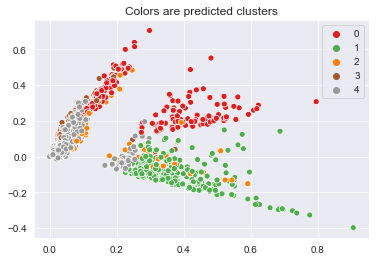

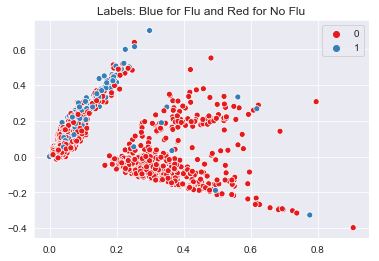

Comparing k-means clusters against the data:
col_0    0    1    2    3     4
label                          
0      161  401  208  156  1565
1       97    5    1   22   507

Adjusted Rand Index: -0.06
Silhouette Score: 0.04
Cluster 0: got shot today sick like week day work feel think bad year
Cluster 1: shot free year time today clinic famili peopl like sick day gotten
Cluster 2: vaccin shot today year protect children free kid studi season peopl everyon
Cluster 3: cold season amp like symptom antibiot make year feel day come hit
Cluster 4: like sick day season feel week time year peopl stomach think come


In [14]:
n_clusters=5
km = KMeans(n_clusters=n_clusters, n_init=30, random_state=0)
y_pred = km.fit_predict(X_train_lsa)

# Plot the solution.
sns.scatterplot(X_train_lsa[:, 0], X_train_lsa[:, 1], hue=y_pred, legend='full', palette='Set1')
plt.title('Colors are predicted clusters')
plt.show()

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)

sns.scatterplot(X_train_lsa[:, 0], X_train_lsa[:, 1], hue=y_train_enc, legend='full', palette='Set1')
plt.title('Labels: Blue for Flu and Red for No Flu')
plt.show()
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, y_pred))


print('\nAdjusted Rand Index: {:.2f}'.format(metrics.adjusted_rand_score(y_train, y_pred)))
print('Silhouette Score: {:.2f}'.format(metrics.silhouette_score(X_train_lsa, 
                                                                 y_pred, 
                                                                 metric='euclidean')))

# Find the words corresponding to the cluster centroids
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = vectorizer_tfidf.get_feature_names()
for i in range(5):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :12]:
        print(' %s' % terms[ind], end='')
    print()

### Here we can see that the first cluster talks about vaccines and the flue season

### Second cluster talks more about getting the flu shot

### Third cluster 

In [15]:

svd = TruncatedSVD(n_components=100, n_iter=25, random_state=0)
truncated_bag_of_words = svd.fit_transform(count_vectordf)

X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(truncated_bag_of_words, 
                                                    df['label'], 
                                                    test_size=0.25, 
                                                    random_state=0)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 61.12366767616514


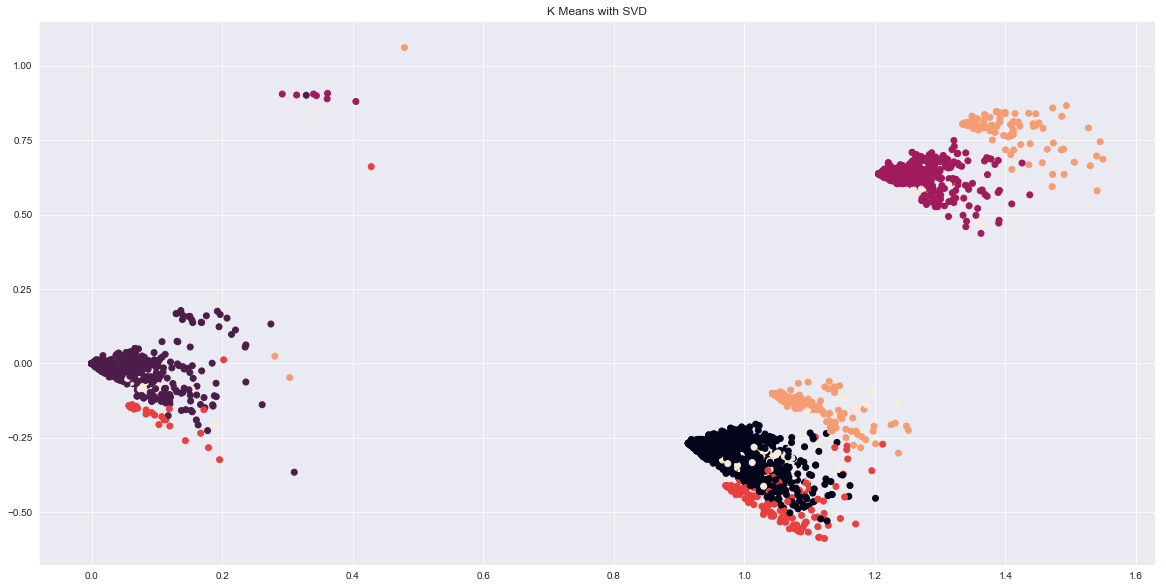

col_0,0,1,2,3,4,5
label,,,,,,
0,836,731,475,152,158,139
1,472,31,6,22,100,1


In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, init='k-means++', random_state=0, n_init=20)

# Fit and predict the model. 
y_pred = kmeans.fit_predict(X_train_svd)

plt.figure(figsize=(20,10))
plt.scatter(X_train_svd[:, 0], X_train_svd[:,1], c=y_pred )
plt.title('K Means with SVD')
plt.show()
pd.crosstab(y_train_svd, y_pred)

# LDA

### While K -means offered us some insight into the type of clusters we can get with tweets, LDA can give us the top topics from our tweets

In [31]:
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to /Users/Fcue/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/Fcue/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 2]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [42]:
df.text_removeRT.to_csv('LDA_tweets_RT.csv', index=False, header=True)
#df.text.to_csv('LDA_tweets.csv', index=False, header=True)
#df.document.to_csv('LDA_document.csv', index=False, header=True)

In [43]:

parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [44]:
import random
text_data = []
with open('LDA_tweets_RT.csv') as f:
    for line in f:
        tokens = prepare_text_for_lda(line)
        if random.random() > .99:
            print(tokens)
            text_data.append(tokens)

['use', 'first', 'time', 'order', 'breathe', 'right']
['kali', 'ini', 'thread', 'top', 'korean', 'disaster', 'movie', 'seriously', 'highly', 'recommend', 'dari', 'aku', 'best', 'gila', 'semua', 'korang', 'kena', 'layan']
['racing', 'community', 'include', 'indycar', 'driver', 'harvey', 'gather', 'last', 'nig‚¶']
['school', 'run', 'do', 'load', 'lanudry', 'potty', 'training', 'meeting', 'take', 'flu', 'spray', 'food', 'shopping']
['new', 'episode', 'stream', 'share']
[]
['saying', 'hehehee', 'say', 'since', 'look', 'ill', 'eyes', 'wonky', 'flulike', 'groom', 'etcheh', 'jus‚¶']
['fun', 'steam', 'lesson', 'today', 'germ', 'amp', 'mold', 'äôs', 'cold', 'amp', 'flu', 'season', 'fun', 'class', 'today', 'drop']
['answer', 'people', 'still', 'get', 'flu', 'even', 'though', 'get', 'flu', 'shot']
['wow', 'real', 'bad', 'stomach', 'flu', 'drop', 'everything', 'come', 'help', 'perish', 'wtf', 'bless']
['probably', 'trump', 'flu']
['flu', 'wake', 'andrea', 'shout', 'get', 'fucking', 'flood', 'inqui

# After building our pipeline for LDA modeling, we can now import gensim to create our dictionary. 

In [45]:

dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [46]:

NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.049*"flu" + 0.033*"get" + 0.017*"year" + 0.017*"vaccine" + 0.017*"days"')
(1, '0.038*"flu" + 0.038*"make" + 0.020*"sure" + 0.020*"want" + 0.020*"big"')
(2, '0.020*"kill" + 0.020*"boy" + 0.020*"humor" + 0.020*"baby" + 0.020*"caugh"')
(3, '0.079*"flu" + 0.027*"sick" + 0.027*"getting" + 0.027*"also" + 0.027*"get"')
(4, '0.035*"flu" + 0.024*"see" + 0.012*"wish" + 0.012*"say" + 0.012*"best"')
(5, '0.048*"flu" + 0.017*"trump" + 0.017*"one" + 0.017*"last" + 0.017*"clinic"')
(6, '0.085*"flu" + 0.040*"get" + 0.033*"shot" + 0.014*"people" + 0.014*"really"')
(7, '0.094*"flu" + 0.038*"shot" + 0.029*"today" + 0.020*"getting" + 0.020*"amp"')
(8, '0.045*"flu" + 0.030*"get" + 0.030*"time" + 0.030*"going" + 0.016*"take"')
(9, '0.029*"like" + 0.029*"thanks" + 0.029*"deliberate" + 0.029*"genocide" + 0.029*"sound"')


In [47]:
new_doc = 'really sick today possibly the flu'
new_doc = prepare_text_for_lda(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)
print(new_doc_bow)
print(ldamodel.get_document_topics(new_doc_bow))

[(34, 1), (72, 1), (105, 1), (263, 1)]
[(0, 0.0200012), (1, 0.020000942), (2, 0.020004494), (3, 0.26571867), (4, 0.020001704), (5, 0.02000223), (6, 0.020008), (7, 0.57425827), (8, 0.020004192), (9, 0.020000309)]


In [48]:
NUM_TOPICS=15
ldamodel5 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel5.save('model5.gensim')
topics = ldamodel5.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.040*"flu" + 0.021*"say" + 0.021*"today" + 0.021*"shit"')
(1, '0.082*"flu" + 0.055*"get" + 0.028*"people" + 0.028*"still"')
(2, '0.003*"jab" + 0.003*"äôm" + 0.003*"going" + 0.003*"alone"')
(3, '0.083*"flu" + 0.043*"think" + 0.043*"well" + 0.003*"going"')
(4, '0.101*"flu" + 0.063*"shot" + 0.038*"get" + 0.026*"hours"')
(5, '0.049*"sure" + 0.049*"make" + 0.025*"flu" + 0.025*"full"')
(6, '0.054*"flu" + 0.028*"readiness" + 0.028*"celebrate" + 0.028*"holiday"')
(7, '0.063*"flu" + 0.032*"get" + 0.022*"kill" + 0.022*"shot"')
(8, '0.003*"fun" + 0.003*"today" + 0.003*"cold" + 0.003*"germ"')
(9, '0.040*"flu" + 0.040*"bath" + 0.040*"playing" + 0.040*"toy"')
(10, '0.078*"flu" + 0.040*"shot" + 0.040*"get" + 0.026*"sick"')
(11, '0.032*"season" + 0.032*"flu" + 0.032*"take" + 0.016*"raise"')
(12, '0.073*"flu" + 0.025*"shot" + 0.025*"get" + 0.025*"birthday"')
(13, '0.044*"flu" + 0.015*"wtf" + 0.015*"everything" + 0.015*"perish"')
(14, '0.050*"flu" + 0.026*"share" + 0.026*"sick" + 0.026*"new"')


In [52]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

In [53]:
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [29]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
